In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [18]:
# Chargement des données
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

print("Train shape:", train.shape)
print("Test shape:", test.shape)


Train shape: (8693, 14)
Test shape: (4277, 13)


In [5]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [6]:
# Vérifier les valeurs manquantes
missing_train = train.isnull().sum()
missing_test = test.isnull().sum()

print("Valeurs manquantes dans le jeu d'entraînement:\n", missing_train)
print("\nValeurs manquantes dans le jeu de test:\n", missing_test)


Valeurs manquantes dans le jeu d'entraînement:
 PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

Valeurs manquantes dans le jeu de test:
 PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


In [20]:
def extract_title(df):
    def get_title(name):
        if pd.isnull(name):
            return "Unknown"  # Gère les valeurs manquantes
        parts = name.split(',')
        if len(parts) > 1:
            sub_parts = parts[1].split('.')
            if len(sub_parts) > 0:
                return sub_parts[0].strip()
        return "Unknown"  # Si le format n'est pas respecté, on retourne "Unknown"
    
    df['Title'] = df['Name'].apply(get_title)
    return df

# Appliquer la fonction aux jeux de données
train = extract_title(train)
test = extract_title(test)

In [21]:
# Variables numériques et catégorielles
numeric_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
categorical_features = ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP']

# Remplissage des valeurs manquantes
for feature in numeric_features:
    median = train[feature].median()
    train[feature].fillna(median, inplace=True)
    test[feature].fillna(median, inplace=True)

for feature in categorical_features:
    mode = train[feature].mode()[0]
    train[feature].fillna(mode, inplace=True)
    test[feature].fillna(mode, inplace=True)


In [22]:
def extract_cabin_features(df):
    df['Deck'] = df['Cabin'].apply(lambda x: x.split('/')[0] if isinstance(x, str) else 'Unknown')
    df['CabinNum'] = df['Cabin'].apply(lambda x: int(x.split('/')[1]) if isinstance(x, str) and x.split('/')[1].isdigit() else -1)
    df['Side'] = df['Cabin'].apply(lambda x: x.split('/')[2] if isinstance(x, str) else 'Unknown')
    return df

train = extract_cabin_features(train)
test = extract_cabin_features(test)


In [23]:
def extract_passengerid_features(df):
    df['GroupId'] = df['PassengerId'].apply(lambda x: x.split('_')[0])
    df['PassengerNumber'] = df['PassengerId'].apply(lambda x: int(x.split('_')[1]))
    return df

train = extract_passengerid_features(train)
test = extract_passengerid_features(test)


KeyError: 'Name'

In [24]:
train.drop(['PassengerId', 'Name', 'Cabin'], axis=1, inplace=True)
test.drop(['PassengerId', 'Name', 'Cabin'], axis=1, inplace=True)

In [28]:
# Mise à jour des listes de features
categorical_features_extended = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side', 'GroupId']
numeric_features_extended = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'CabinNum', 'PassengerNumber']

# Définition du préprocesseur
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_extended),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_extended)
    ])


In [29]:
# Séparation des features et de la cible
X = train.drop('Transported', axis=1)
y = train['Transported'].astype(int)  # Convertir True/False en 1/0

# Division en ensembles d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [30]:
print("Colonnes dans X_train :", X_train.columns)


Colonnes dans X_train : Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Title', 'Deck',
       'CabinNum', 'Side', 'GroupId', 'PassengerNumber'],
      dtype='object')


In [37]:
# Définition du pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    ))
])

# Entraînement du modèle
pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck', 'CabinNum',
                                                   'PassengerNumber']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['HomePlanet', 'CryoSleep',
                                                   'Destination', 'VIP', 'Deck',
                                                   'Side', 'GroupId'])])),
                ('classifier',
                 GradientBoostingClassifier(max_depth=5, random_state=42))])

Accuracy sur l'ensemble de validation: 0.8085

Rapport de classification:
               precision    recall  f1-score   support

           0       0.81      0.80      0.81       863
           1       0.81      0.81      0.81       876

    accuracy                           0.81      1739
   macro avg       0.81      0.81      0.81      1739
weighted avg       0.81      0.81      0.81      1739



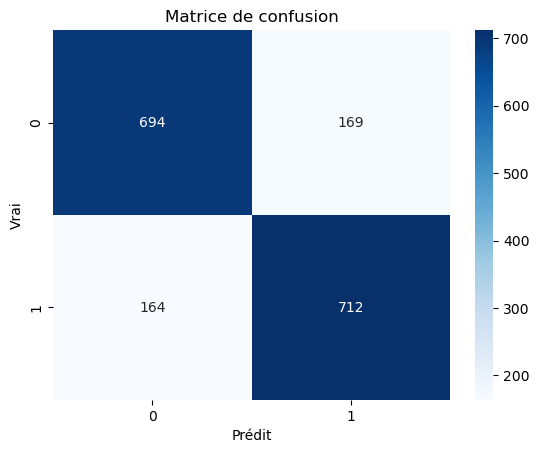

In [38]:
# Prédictions
y_pred = pipeline.predict(X_val)

# Calcul de l'accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy sur l\'ensemble de validation: {accuracy:.4f}')

# Rapport de classification
print("\nRapport de classification:\n", classification_report(y_val, y_pred))

# Matrice de confusion
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prédit')
plt.ylabel('Vrai')
plt.title('Matrice de confusion')
plt.show()


In [40]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Définir le pipeline avec XGBoost
from sklearn.pipeline import Pipeline

xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    ))
])

# Entraînement
xgb_pipeline.fit(X_train, y_train)

# Prédictions et évaluation
y_pred_xgb = xgb_pipeline.predict(X_val)
accuracy_xgb = accuracy_score(y_val, y_pred_xgb)
print(f'Accuracy avec XGBoost: {accuracy_xgb:.4f}')

Accuracy avec XGBoost: 0.8028


In [34]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7],
    'classifier__subsample': [0.6, 0.8, 1.0],
    'classifier__min_samples_split': [2, 5, 10]
}

random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=50,
    scoring='accuracy',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)
print("Meilleurs paramètres :", random_search.best_params_)
print("Meilleur score d'accuracy :", random_search.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Meilleurs paramètres : {'classifier__subsample': 0.6, 'classifier__n_estimators': 100, 'classifier__min_samples_split': 5, 'classifier__max_depth': 7, 'classifier__learning_rate': 0.05}
Meilleur score d'accuracy : 0.8052919183203912


In [33]:
# Encodage des features du jeu de test
X_test = test.copy()

# Prédictions sur le jeu de test
y_test_pred = pipeline.predict(X_test)

# Conversion des prédictions en True/False
y_test_pred_bool = y_test_pred.astype(bool)

# Préparation du fichier de soumission
submission['Transported'] = y_test_pred_bool

# Sauvegarde du fichier de soumission
submission.to_csv('submission.csv', index=False)
print("Fichier de soumission 'submission.csv' généré avec succès.")


Fichier de soumission 'submission.csv' généré avec succès.
